In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import minimize_scalar

### Air Source Heat Pump Experimentation
The goal of this notebook is to model the heating energy usage of a building throughout an average winter, and understand how an air source heat pump would operate in this environment.

1. In this notebook we build up weather bin data over a 40 year history in Corona CA (https://home.openweathermap.org/history_bulks/new).
2. Given the building design parameters (gleaned from a Manual-J report), we estimate the distribution of building loads over air temperature.
3. We also model the performance, in terms of capacity and output of the Chiltrix CX34 inverter driven system.

### Load 1 hour weather bars

In [4]:
weather = pd.read_csv('./fba83c6924b0b37bfa1402d44441047f.csv')
weather['date']=pd.to_datetime(weather['dt']*1000000000.0).dt.date
weather['year']=pd.to_datetime(weather['date']).dt.year
weather['month']=pd.to_datetime(weather['date']).dt.month
weather['month_cat']=weather['month'].astype('category')
weather=weather.query('year<2020').copy()
weather=weather.merge(weather.groupby('date')['temp'].min().to_frame('min_daily_temp'), on='date')
weather=weather.merge(weather.groupby('date')['temp'].max().to_frame('max_daily_temp'), on='date')
weather['outside_temp']=weather['temp'].round()
weather['is_heating_day']=1.0*((weather['min_daily_temp']<=55)&(~weather['month'].isin([6,7,8,9])))
heating_day = weather.query('is_heating_day==1.0')

### View of the weather data

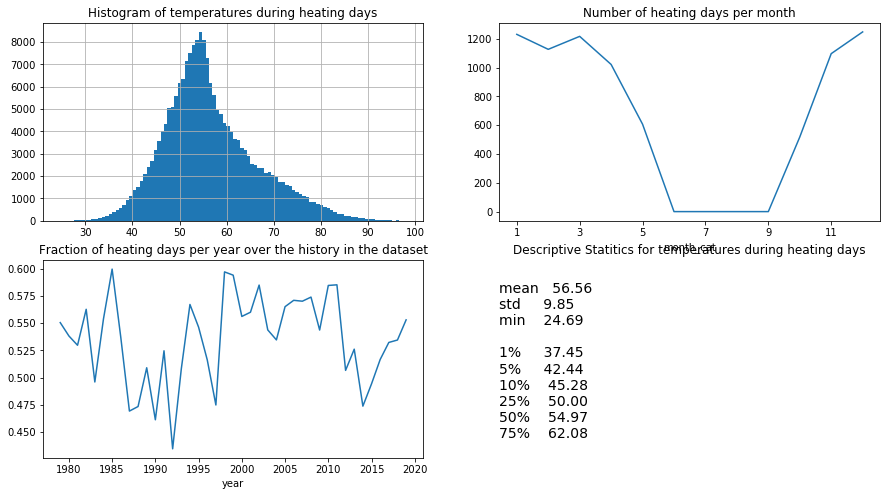

In [5]:
fig,axes=plt.subplots(2,2,figsize=(15,8))
axes=axes.reshape(-1)
heating_day['temp'].hist(bins=100,ax=axes[0])
axes[0].set_title('Histogram of temperatures during heating days')
axes[1].set_title('Number of heating days per month')
heating_day.groupby('month_cat')['date'].nunique().plot(ax=axes[1])
axes[2].set_title('Fraction of heating days per year over the history in the dataset')
weather.groupby('year')['is_heating_day'].mean().plot(ax=axes[2])
desc=heating_day['temp'].describe(percentiles=[.01,.05,.10,.25,.50,.75])[['mean', 'std', 'min', '1%', '5%', '10%', '25%', '50%', '75%']]
_= axes[3].text(0,.1,desc.to_string(float_format='%.2f').replace('\n','\n\n',3).replace('\n\n','\n',2),fontsize=14)
axes[3].get_xaxis().set_visible(False)
axes[3].get_yaxis().set_visible(False)
_ = axes[3].axis('off')
_ = axes[3].set_title('Descriptive Statitics for temperatures during heating days')

### Build the design conditions

In [6]:
design_load=18500 # BTUS/hr
design_outdoor_temp=int(desc['1%']) # ~13 Degrees
design_indoor_temp=70 #degree F
design_supply_temp=95 #degree F
design_dt=design_indoor_temp-design_outdoor_temp #difference between indoor and outdoor on "coldest" hour of the year

#### Build the temperature bin data.

In [7]:
bin_data=heating_day.groupby(['year','outside_temp'])['dt'].nunique().unstack(0).fillna(0).mean(axis=1).to_frame('num_hours').reset_index()

In [8]:
#Current design delta-t
bin_data['dt']=(design_indoor_temp-bin_data['outside_temp'])
#Fraction of the design load
bin_data['pct_of_design_load']=(bin_data['dt'])/design_dt
# Load at this outdoor temp
bin_data['load']=bin_data['pct_of_design_load']*design_load
# Ignore scenarios below or above design conditions
bin_data=bin_data.query('(pct_of_design_load>=0)&(pct_of_design_load<=1)').copy()
#Number of hours at or above the current load and by %
bin_data['num_hours_at_or_above_load']=bin_data.sort_values(by='pct_of_design_load',ascending=False)['num_hours'].cumsum()
bin_data['pct_time_at_or_above_load']=bin_data['num_hours_at_or_above_load']/(bin_data['num_hours_at_or_above_load'].max())

#Building load function
building_load = lambda outside_temp: ((design_indoor_temp-outside_temp)/design_dt)*design_load

#Supply Water temperature as a function of load and design max temp, max temp setting requires 
# consulting radiator design/manual-J
swt_slope=(design_supply_temp-design_indoor_temp)/design_dt
swt = lambda x: swt_slope*(design_indoor_temp-x) + design_indoor_temp
swt_intercept=swt(0)

#from SWT -> outdoor temp
swtinv = lambda swt: (design_indoor_temp-swt)*design_dt/(design_supply_temp-design_indoor_temp) + design_indoor_temp

#SSI Capacity and COP courtesy of John Seigenthaler
bin_data['SWT']=bin_data['outside_temp'].apply(swt)
b1 = lambda ts: .047865-.000259098*ts
b2 = lambda ts: 5.505128e-5 - 9.0026e-7*ts + (3.9629e-9)*ts**2
COP = lambda tout: (4.82-.026*swt(tout)) + b1(swt(tout))*tout + b2(swt(tout))*tout**2
q = lambda tout: (56518-100.6385*swt(tout))  + (709.32-1.26291*swt(tout))*tout
bin_data['SSI_output']=bin_data[['SWT','outside_temp']].apply(lambda row: min(q(row['outside_temp']),33813),axis=1)
bin_data['SSI_COP']=bin_data[['SWT','outside_temp']].apply(lambda row: min(COP(row['outside_temp']),3.92),axis=1)

#Automatically compute the balance point where SSI output matches the building load
fmin = lambda x: np.abs(q(x)-building_load(x))
res=minimize_scalar(fmin,bounds=(0,design_indoor_temp), method='bounded')
balance_point=res.x
print(res)

     fun: 4893.997142690125
 message: 'Solution found.'
    nfev: 34
  status: 0
 success: True
       x: 5.489316496188152e-06


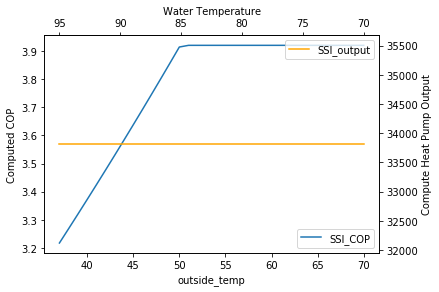

In [9]:
ax=bin_data.set_index('outside_temp')[['SSI_COP']].plot()
ax.legend(loc=4)
ax.set_ylabel('Computed COP')
ax=bin_data.set_index('outside_temp')[['SSI_output']].plot(ax=ax.twinx(),color='orange')
ax.set_ylabel('Compute Heat Pump Output')
plt.locator_params(nbins=10)
new_ax=ax.secondary_xaxis('top', functions=(swt,swtinv))
new_ax.set_xlabel('Water Temperature')
_=new_ax.set_xticks((154,140,130,120,110,100,95,90,85,80,75,70))

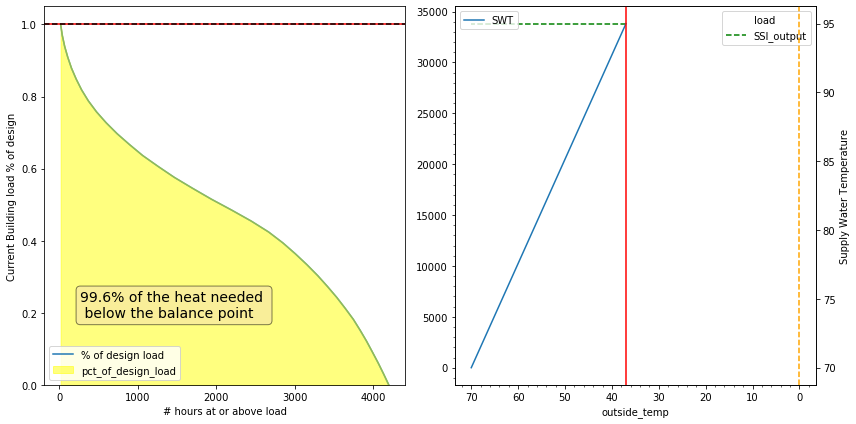

In [10]:
fig,axes=plt.subplots(1,2,figsize=(12,6))
fig.suptitle('Comparison of Time Spent at various building loads compared to SSI capacity')
plt.minorticks_on()
axes=axes.reshape(-1)
ax=axes[0]
bin_data.plot(x='num_hours_at_or_above_load',y='pct_of_design_load',label='% of design load',ax=ax)
bin_data.plot.area(x='num_hours_at_or_above_load',y='pct_of_design_load',color='yellow',alpha=0.5,ax=ax)
ax.set_xlabel('# hours at or above load')
ax.set_ylabel('Current Building load % of design')
ax=axes[1]
bin_data.plot(x='outside_temp',y='load',color='white',ax=ax)
ax.invert_xaxis()
ax1=ax.twinx()
ax1.set_ylabel('Building Load')
bin_data.plot(x='outside_temp',y='SWT',ax=ax1)
ax1.set_ylabel('Supply Water Temperature')
ax1.axvline(design_outdoor_temp,color='r')
bin_data.plot(x='outside_temp',y='SSI_output',ax=ax,style='--',color='g')
fig.suptitle('', fontsize=12,y=1.1)
fig.tight_layout()
axes[0].axhline(1.0,color='r',label='design load')
balance_idx=(bin_data['outside_temp']-balance_point).abs().argmin()
bp_bin=bin_data.iloc[balance_idx]
ax1.axvline(balance_point,color='orange',ls='--')
axes[0].axhline(bp_bin['pct_of_design_load'].item(),ls='--',color='black')
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
below_balance=100*(1-bp_bin['pct_time_at_or_above_load'].item())
# place a text box in upper left in axes coords
_ = axes[0].text(0.1, .25, f'{below_balance:.01f}% of the heat needed \n below the balance point', 
             transform=axes[0].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

#### These systems still provide considerable heat in this design when temperatures drop below the balance point, the COP > 1
#### It's far more efficient than a gas boiler, with a COP typically between .6-.9 at these conditions

In [11]:
pd.Series([100*q(design_outdoor_temp)/building_load(design_outdoor_temp), 
swt(design_outdoor_temp), 
COP(design_outdoor_temp)],index=['Percentage of heat supplied by SSI @ Design Temp',
                                 'Design water temperature','COP at design'])

Percentage of heat supplied by SSI @ Design Temp    371.692183
Design water temperature                             95.000000
COP at design                                         3.217520
dtype: float64

### This is the average COP above our balance point

In [12]:
np.average(bin_data.query('outside_temp>=@balance_point')['SSI_COP'], 
           weights=bin_data.query('outside_temp>=@balance_point')['num_hours'])

3.8526169860698625

### This is the energy delivered in each outdfoor temperature bin, and the energy required

In [13]:
bin_data['btus_in_bin']=bin_data['load']*bin_data['num_hours']
bin_data['kwh_in_bin']=(bin_data['btus_in_bin']*0.000293071)
bin_data['kwh_required']=(bin_data['kwh_in_bin']/bin_data['SSI_COP'])
bin_data['therms_in_bin']=(bin_data['btus_in_bin']/99976)

In [14]:
def custom_round(x, base=5):
    return int(base * round(float(x)/base))
bin_data['round_outside_temp']=bin_data['outside_temp'].apply(custom_round)
bin_data['round_ssi_cop']=(10*bin_data['SSI_COP']).apply(custom_round)/10

### Shows the disparity of heating energy delivered in KWH versus heating energy consumed by the heat pump

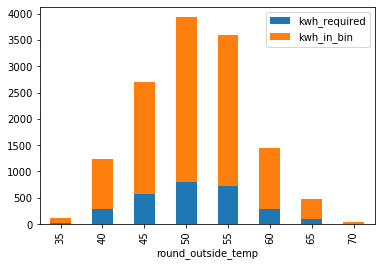

In [15]:
bin_data.groupby('round_outside_temp')[['kwh_required','kwh_in_bin']].sum().plot.bar(stacked=True)

In [16]:
bin_data['above_balance']=(bin_data['outside_temp']>=balance_point)

In [17]:
energy_del_vs_required = bin_data.groupby('above_balance')[['kwh_in_bin','kwh_required']].sum()

### Serious reductions of total energy needed from the energy grid.
### 66% reduction above the balance point.

In [18]:
100*(1-energy_del_vs_required['kwh_required']/energy_del_vs_required['kwh_in_bin'])

above_balance
True    73.650679
dtype: float64

### Remaining fraction of total energy from supplemental heat source.

In [20]:
100*(energy_del_vs_required['kwh_in_bin'][False]/(energy_del_vs_required['kwh_in_bin'][False]+energy_del_vs_required['kwh_in_bin'][True]))

KeyError: False

### Total % reduction in energy from grid

In [21]:
100*(1-energy_del_vs_required['kwh_required'].sum()/energy_del_vs_required['kwh_in_bin'].sum())

73.65067922574764

### # of hours at each COP above the balance point

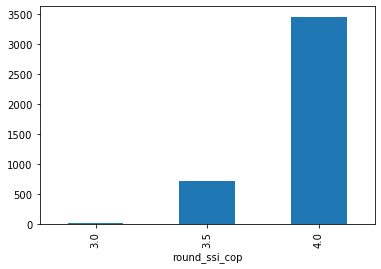

In [22]:
bin_data.query('outside_temp>=@balance_point').groupby('round_ssi_cop')['num_hours'].sum().plot.bar()